## Projet Data Mining réalisé par:
- ABABII Anisoara
- GAUTIER Baptiste

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "darkgrid")

In [3]:
pwd

'c:\\Users\\ababi\\Desktop\\Data_mining_Project_Mosef-main\\Data_mining_Project_Mosef-main'

# Chargement du dataset et analyse descriptive

### Chargement des datasets et merge

In [4]:
tourisme_dataset = pd.read_csv(r"data/base-cc-tourisme-2022-geo2022-CSV/base-cc-tourisme-2022-geo2022.csv", 
                               encoding='utf8',
                               delimiter=";",
                               low_memory=False)
population_dataset = pd.read_excel(r"data/base-pop-historiques-1876-2019.xlsx")
print(f"Datasets fusionnable sur les colonnes : {*[x for x in population_dataset.columns if x in tourisme_dataset.columns],}")
merged_df = tourisme_dataset.merge(population_dataset, on = "CODGEO", how = "inner")

Datasets fusionnable sur les colonnes : ('CODGEO',)


### Analyse des outliers

In [5]:
from src.tools import remove_outliers

On considère toutes les valeurs supérieurs au 9e décile comme des outliers. C'est une solution extrême, mais motivée par le fait que de nombreuses valeurs sont très détachées du reste des points, ce qui écrase fortement la distribution.

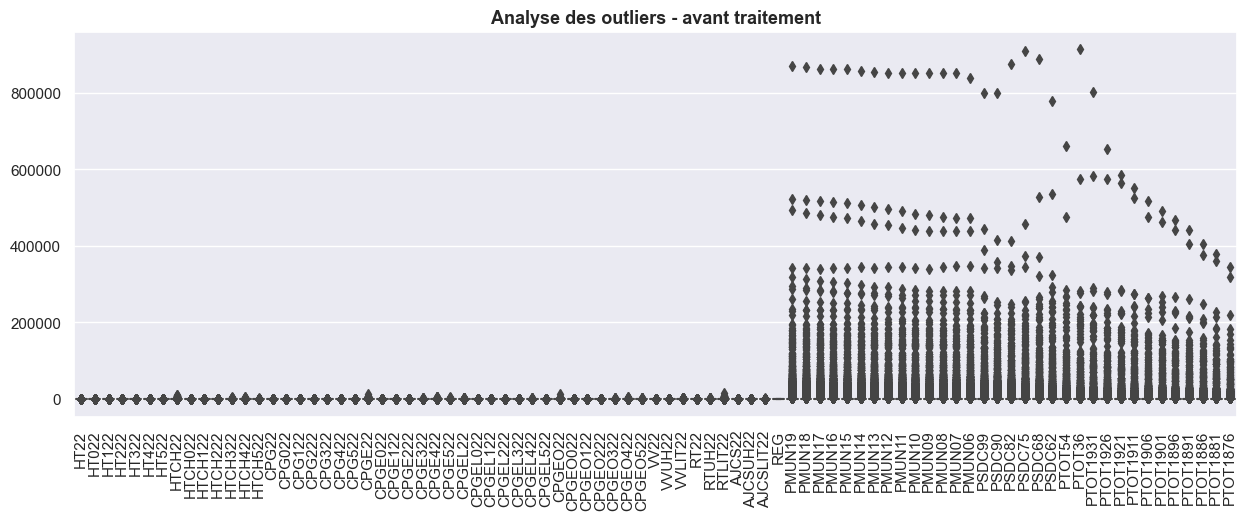

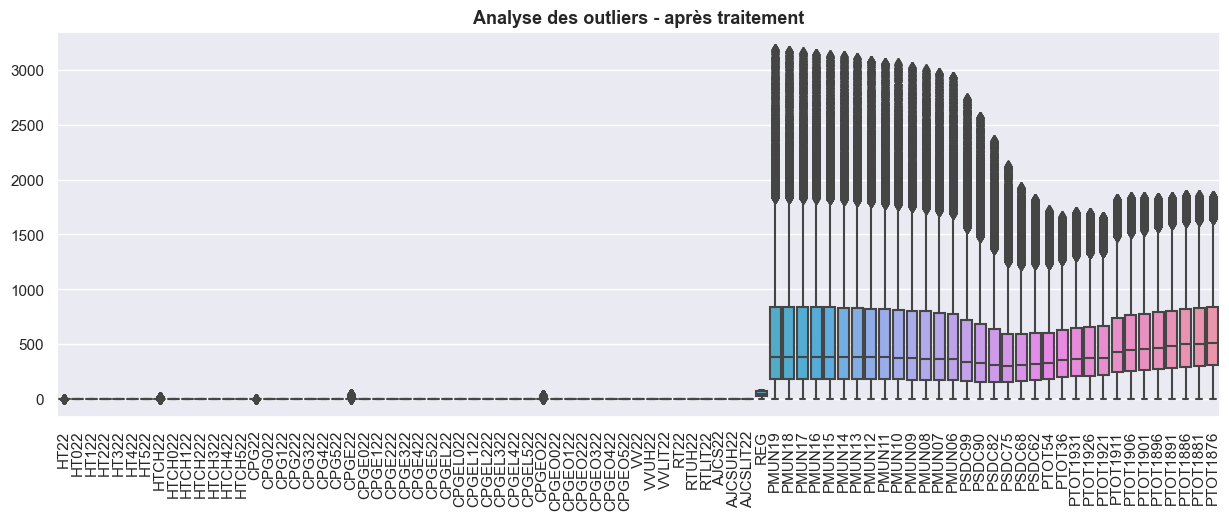

In [6]:
merged_df = remove_outliers(merged_df, merged_df.select_dtypes(include = np.number).columns.tolist(), seuil = .90)

### Analyse des valeurs manquantes

In [7]:
from src.tools import visualize_nan

Shape : (34957, 88)


c:\Users\ababi\Desktop\Data_mining_Project_Mosef-main\Data_mining_Project_Mosef-main\src\tools.py:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(["Présent", "Manquant"], fontsize=12)


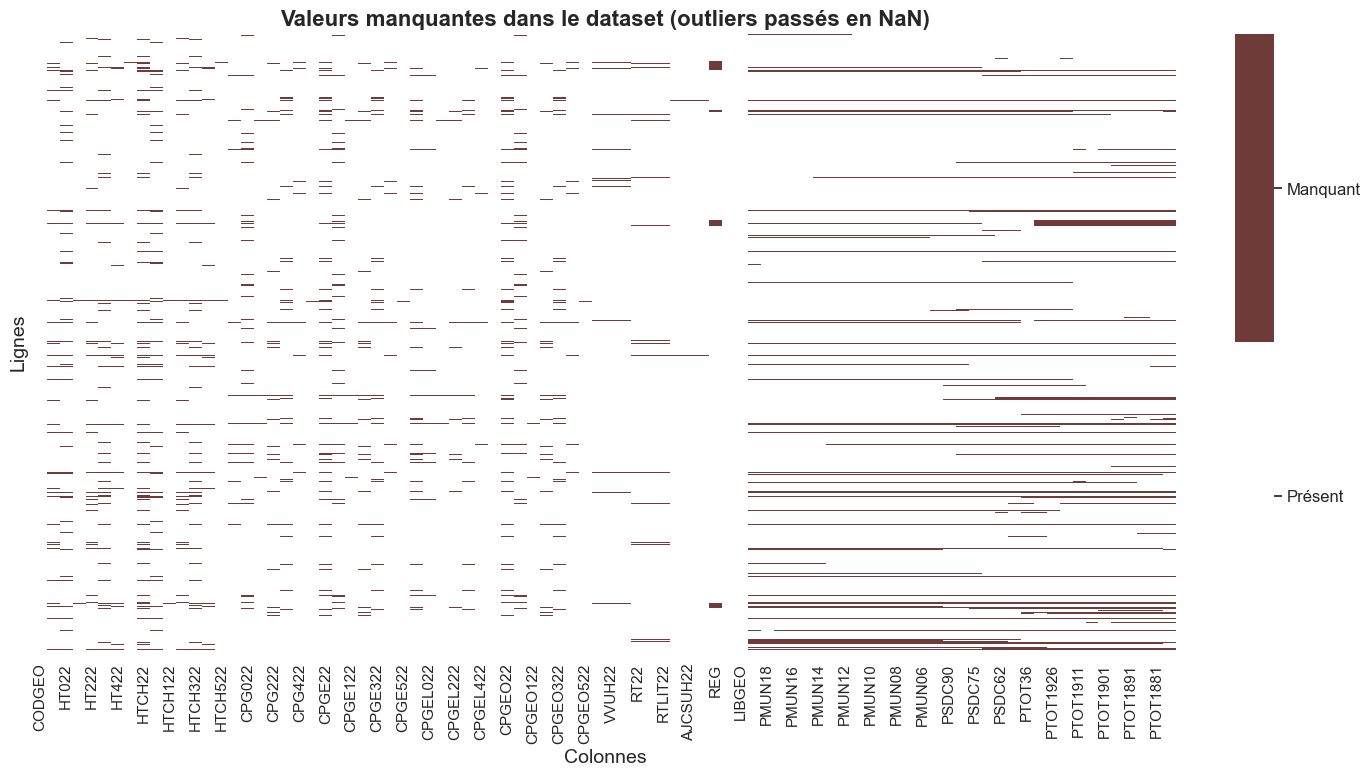

In [8]:
visualize_nan(merged_df, "Valeurs manquantes dans le dataset (outliers passés en NaN)")

In [9]:
print(f"{merged_df.select_dtypes(include = np.number).shape[1]} colonnes numériques dans le jeu de données sur {merged_df.shape[1]}.")

85 colonnes numériques dans le jeu de données sur 88.


### Imputation des valeurs manquantes

De par le fort nombre de variables numériques, il peut être pertinent d'imputer les variables par les K plus proches voisins. Cette technique se basant sur des distances, avoir un grand nombre de variables numériques permet de proposer une imputation intéressante.

In [10]:
from sklearn.impute import KNNImputer
# TESTER LE NOMBRE OPTIMAL DE VOISINS

In [37]:
# from src.tools import find_best_knn
# #### Long à faire tourner
# best_choice = find_best_knn(merged_df, merged_df.select_dtypes(include = float).columns)

# imputer = KNNImputer(n_neighbors=best_choice)
# merged_df[merged_df.select_dtypes(include = np.number).columns] = imputer.fit_transform(merged_df.select_dtypes(include = np.number))

In [11]:
# Pour comparer les statistiques du jeu de données avant et après imputation
description = merged_df.select_dtypes(include = np.number).describe()

In [12]:
imputer = KNNImputer(n_neighbors=5)
merged_df[merged_df.select_dtypes(include = np.number).columns] = imputer.fit_transform(merged_df.select_dtypes(include = np.number))

In [13]:
print(f'{merged_df.isna().sum().sum()} variables manquantes restantes après imputation')

0 variables manquantes restantes après imputation


In [14]:
description = merged_df.select_dtypes(include = float).describe()
# La moyenne, la variance ainsi que les quantiles sont très légérements impactés par l'imputation des valeurs manquantes

### Analyse des corrélations

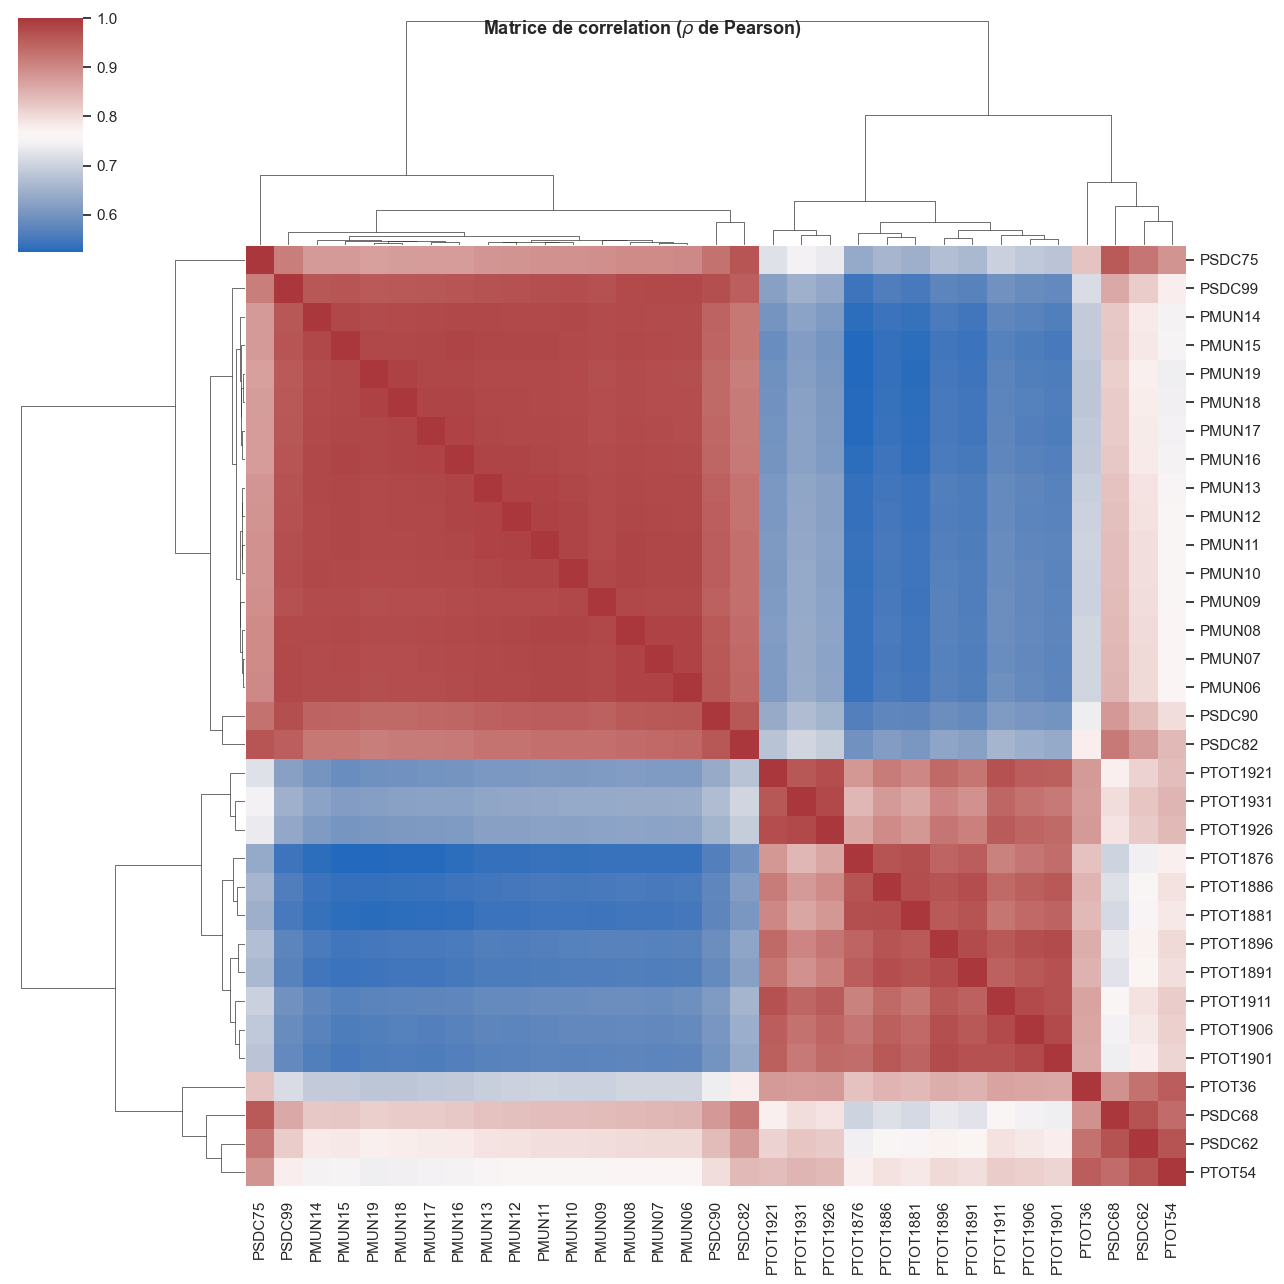

In [15]:
g = sns.clustermap(merged_df.loc[:, [x for x in merged_df.columns if 'PM' in x or 'PS' in x or 'PTOT' in x]].corr().fillna(0), cmap='vlag', cbar_kws={"shrink": .5}, figsize = (13, 13))
g.fig.suptitle(r"Matrice de correlation ($\rho$ de Pearson)", fontsize = 13, fontweight = "bold")
_ = plt.show()

Les variables avec des préfixes similaires sont fortements corrélées notamment les variables relatives à la population. Cela fait sens, la population d'une ville à une période t est forcément liée à la population de cette même ville à une période t+1 (sauf cas de catastrophe).

Au vu des résultats, nous préssentons pour l'ACP que les axes seront représentatifs des groupes formés par les préfixes, et notamment les gros clusters de variables corrélés comme les variables de "PMUN" à "PTOT".

# Réduction de dimension (ACP)

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

On standardise les données pour leur donner une variance de 1 et une moyenne de 0. Cela permet d'éviter les problèmes dûes aux échelles différentes des variables. Cette etape consiste à soustraire la moyenne et à la diviser par l’écart type.
Grace à la standardisation nous aurons une meilleure visualisation de heatmap et l'ACP.

In [17]:
sc = StandardScaler()
X_scaled = sc.fit_transform(merged_df.select_dtypes(include=np.number)) # 

Les variables qualitatives sont les libellés des villes et département
Ils ne nous seront pas utiles dans l'ACP, en revanche nous les utiliserons après pour analyser les résultats

In [18]:
acp = PCA(n_components=15) # On veut deux composantes principales pour la visualisation
acp.fit(X_scaled)

PCA(n_components=15)

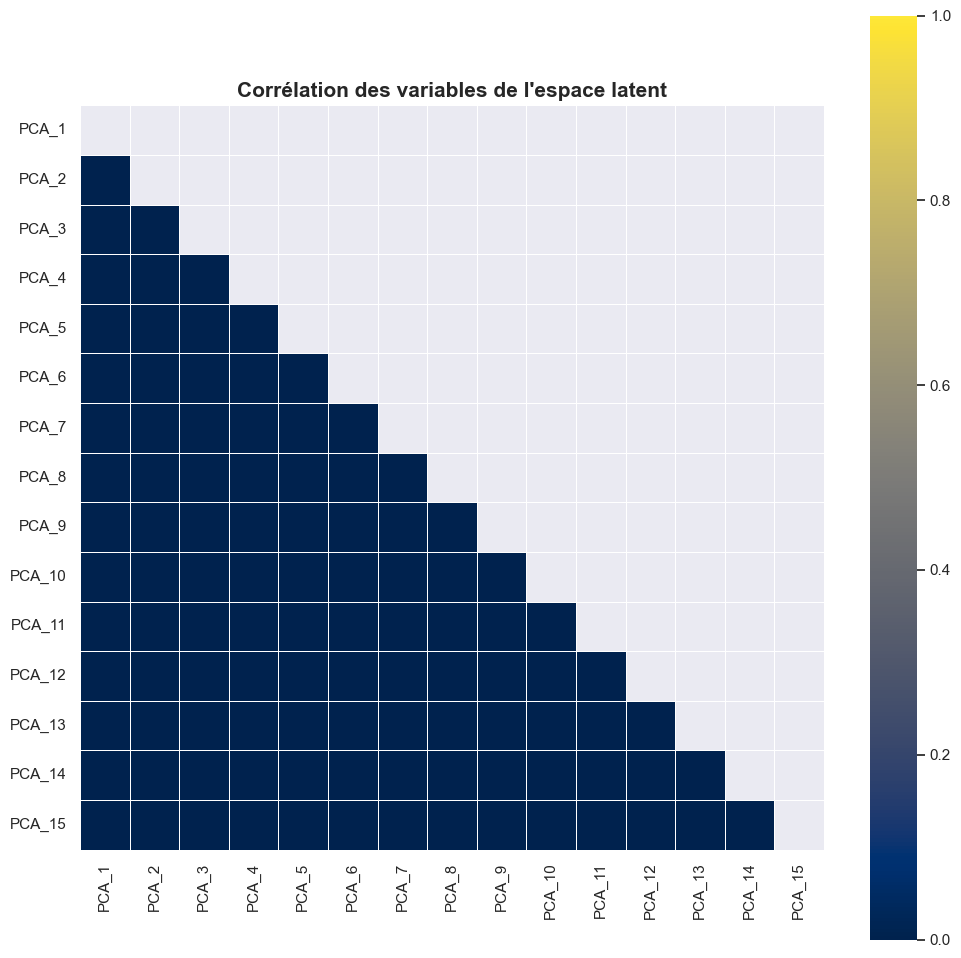

In [19]:
# Logiquement, la corrélation entre les variables de l'espace latent devrait être proche de 0
latent_space = acp.transform(X_scaled)

plt.figure(figsize=(12, 12))
plt.title("Corrélation des variables de l'espace latent", fontsize = 15, fontweight = "bold")
sns.heatmap(pd.DataFrame(latent_space, columns=["PCA_"+str(x) for x in np.arange(1, 16, 1)]).corr(),
            mask = np.triu(pd.DataFrame(latent_space, columns=["PCA_"+str(x) for x in np.arange(1, 16, 1)]).corr()),
            annot = False,
            square=True,
            linewidths=.5,
            vmin = 0,
            vmax = 1,
            cmap = "cividis")
_ = plt.show()

L'ACP à bien fonctionnée et les résultats sont cohérents (composantes principales non corrélées)

### Les % de variance expliquées 

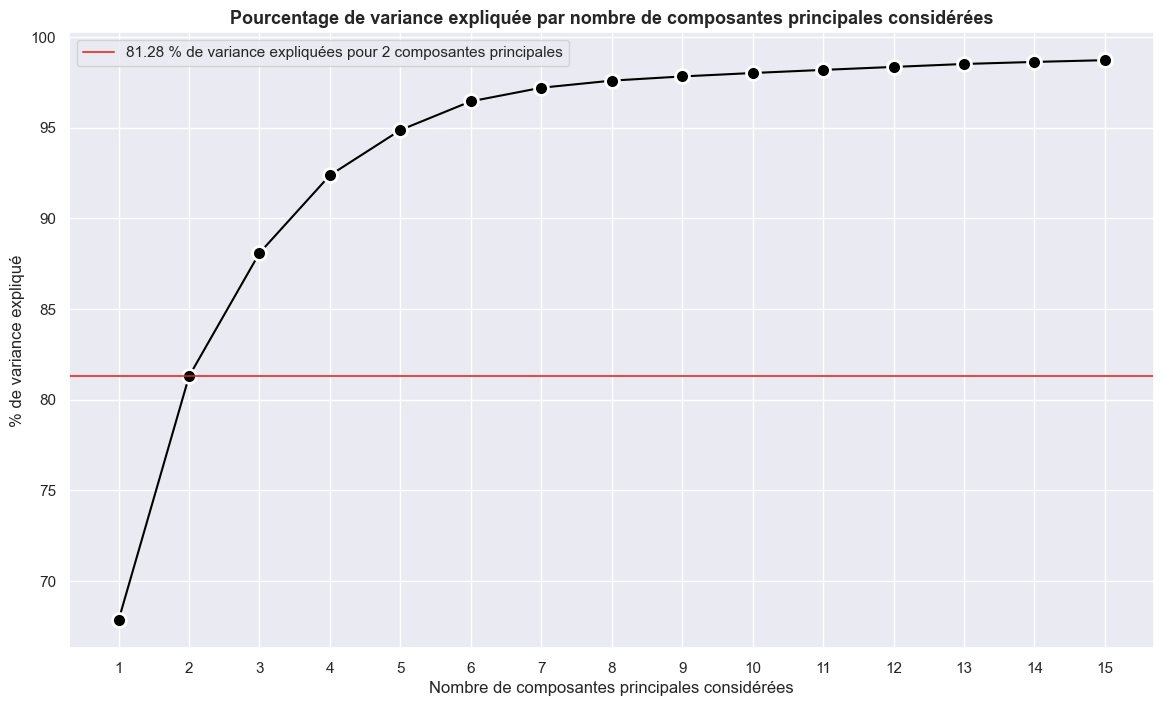

In [20]:
# On veut voir les % de variance expliquées 
plt.figure(figsize = (14, 8))
plt.title("Pourcentage de variance expliquée par nombre de composantes principales considérées", fontweight = "bold", fontsize = 13)
plt.plot([acp.explained_variance_ratio_[:i].sum() * 100 for i in range(1, 16, 1)], 
         marker = "o", 
         color = "black",
         markeredgewidth = 2, 
         markersize = 10,
         markeredgecolor = "white")
plt.axhline(y = acp.explained_variance_ratio_[:2].sum() * 100, label = f"{acp.explained_variance_ratio_[:2].sum() * 100:.2f} % de variance expliquées pour 2 composantes principales",
            color = "tab:red", 
            alpha = .8)
plt.ylabel("% de variance expliqué")
plt.xlabel("Nombre de composantes principales considérées")
plt.xticks(ticks = np.arange(0, 15, 1), labels=np.arange(1, 16, 1))
plt.legend()
plt.show()

In [21]:
print(f"2 composantes principales nous permettent d'expliquer {acp.explained_variance_ratio_[:2].sum() * 100:.2f}% de variance expliquée.")

2 composantes principales nous permettent d'expliquer 81.28% de variance expliquée.


In [22]:
# De quelles variables nos composantes principales sont explicatives ?
copied_df = merged_df.copy()
copied_df["PC1"] = latent_space[:, 0]; copied_df["PC2"] = latent_space[:, 1]
corr_pcs = copied_df.corr().filter(items = ["PC1", "PC2"], axis = 0).drop(labels = ["PC1", "PC2"], axis = 1).T

correlated_values_pc1 = [indexes for indexes in corr_pcs["PC1"].index if corr_pcs.loc[indexes, "PC1"] > 0.9] # Variables expliquées par la PC1
correlated_values_pc2 = [indexes for indexes in corr_pcs["PC2"].index if corr_pcs.loc[indexes, "PC2"] > 0.6] # Variables expliquées par la PC2
# La PC2 est moins fortement corréléé aux valeurs, on baisse le seuil

C:\Users\ababi\AppData\Local\Temp\ipykernel_3636\1483337263.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_pcs = copied_df.corr().filter(items = ["PC1", "PC2"], axis = 0).drop(labels = ["PC1", "PC2"], axis = 1).T


In [23]:
print("PC1 / variables représentatives (pearson 0.9) :", correlated_values_pc1)
print("\n")
print("PC2 / variables représentatives (pearson 0.6) :", correlated_values_pc2)

PC1 / variables représentatives (pearson 0.9) : ['PMUN19', 'PMUN18', 'PMUN17', 'PMUN16', 'PMUN15', 'PMUN14', 'PMUN13', 'PMUN12', 'PMUN11', 'PMUN10', 'PMUN09', 'PMUN08', 'PMUN07', 'PMUN06', 'PSDC99', 'PSDC90', 'PSDC82', 'PSDC75', 'PSDC68', 'PSDC62', 'PTOT54']


PC2 / variables représentatives (pearson 0.6) : []


Les variables qui influencent la position sur l'axe 1 sont les variables relatives à la population. En revanche, l'axe 2 semble un peu plus flou, aucune variable semble fortement corrélée à ce dernier. 

In [24]:
acp_df = pd.DataFrame()
acp_df["PC1"] = latent_space[:, 0]
acp_df["PC2"] = latent_space[:, 1]
acp_df["LIBGEO"] = merged_df["LIBGEO"]

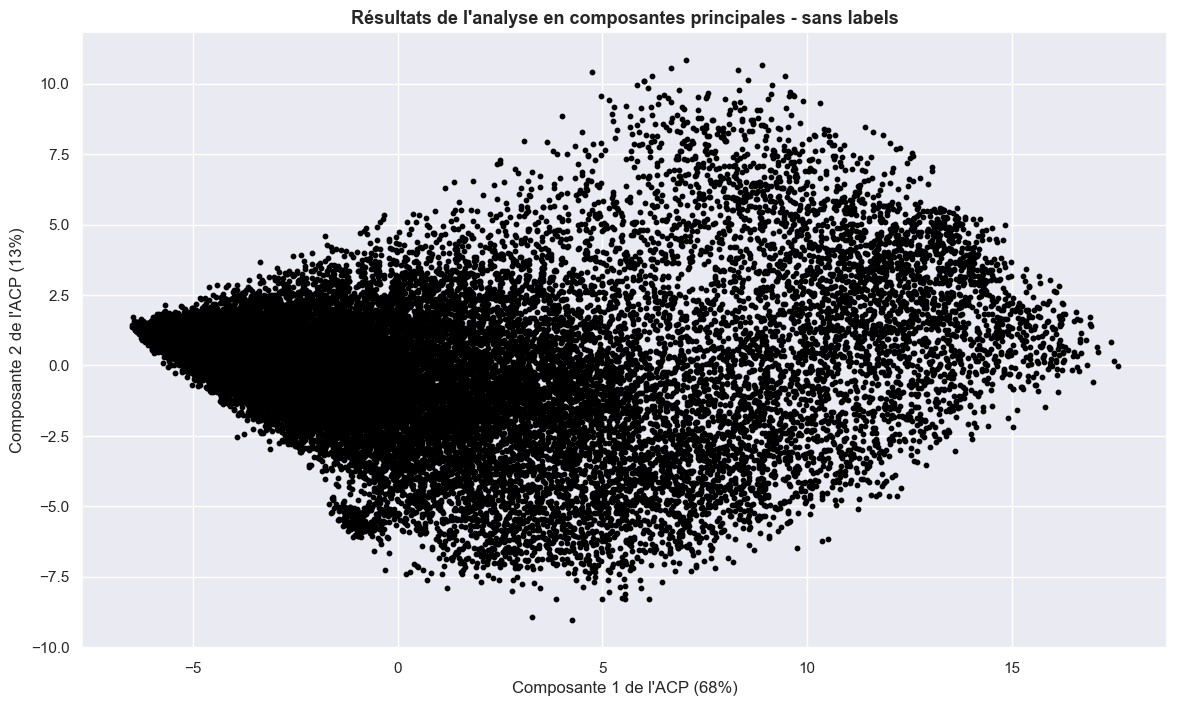

In [25]:
# Representer graphiquement les departements sur les deux premieres composante de l'acp
plt.figure(figsize = (14, 8))

plt.scatter(latent_space[:, 0], latent_space[:, 1], s = 10, color = "black")
    
plt.xlabel(f"Composante 1 de l'ACP ({acp.explained_variance_ratio_[0] * 100:.0f}%)")
plt.ylabel(f"Composante 2 de l'ACP ({acp.explained_variance_ratio_[1] * 100:.0f}%)")
plt.title("Résultats de l'analyse en composantes principales - sans labels", fontsize = 13, fontweight = "bold")
plt.show()

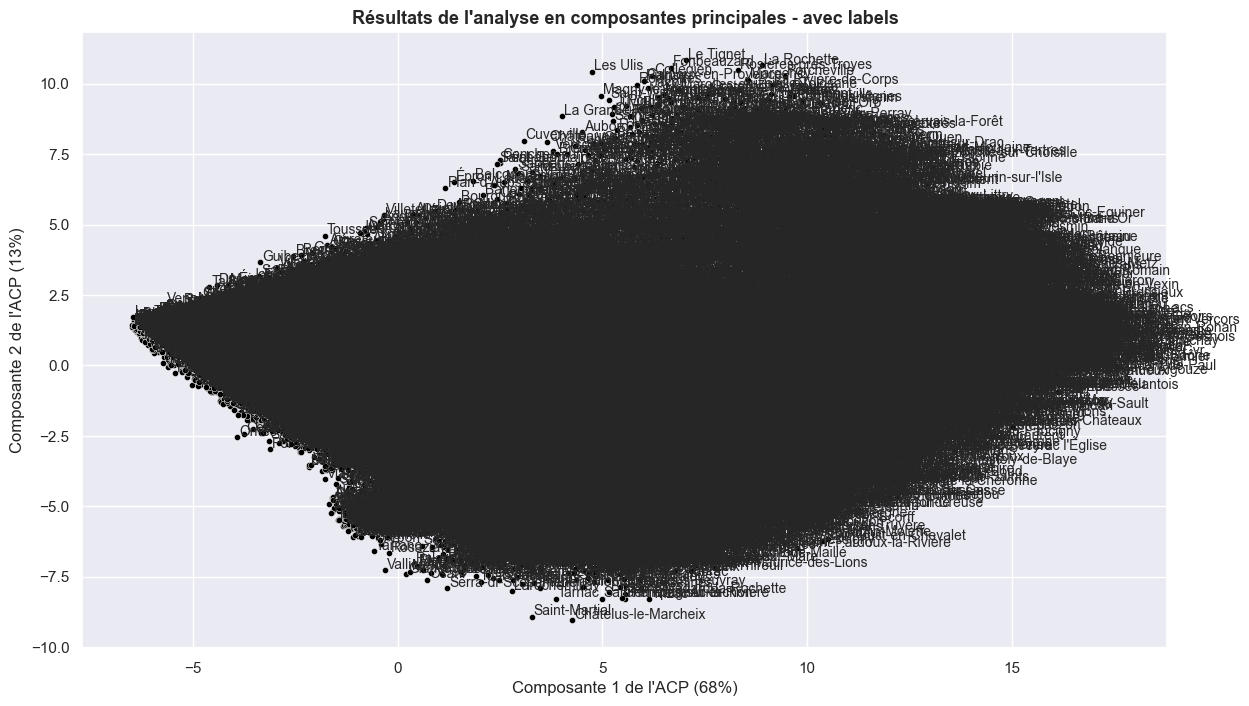

In [26]:
plt.figure(figsize = (14, 8))
sns.scatterplot(data = acp_df, x = "PC1", y = "PC2", s = 20, color = "black", marker = "o", alpha = 1, legend = None)
for i in acp_df.index:
    plt.text(acp_df["PC1"].iloc[i] + 0.05,
            acp_df["PC2"].iloc[i] + 0.05,
            acp_df["LIBGEO"].iloc[i],
            fontdict={"fontsize":10}) 
plt.xlabel(f"Composante 1 de l'ACP ({acp.explained_variance_ratio_[0] * 100:.0f}%)")
plt.ylabel(f"Composante 2 de l'ACP ({acp.explained_variance_ratio_[1] * 100:.0f}%)")
plt.title("Résultats de l'analyse en composantes principales - avec labels", fontsize = 13, fontweight = "bold")
plt.show()

# Clustering

In [27]:
# Matrice de variance-covariance des données
pd.DataFrame(np.cov(merged_df.select_dtypes(include = np.number).T), columns = merged_df.select_dtypes(include = np.number).columns, index = merged_df.select_dtypes(include = np.number).columns) 

HT22  HT022  HT122  HT222  HT322  HT422  HT522      HTCH22  \
HT22       0.090364    0.0    0.0    0.0    0.0    0.0    0.0    0.840310   
HT022      0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.000000   
HT122      0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.000000   
HT222      0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.000000   
HT322      0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.000000   
...             ...    ...    ...    ...    ...    ...    ...         ...   
PTOT1896  32.459733    0.0    0.0    0.0    0.0    0.0    0.0  294.276356   
PTOT1891  32.313096    0.0    0.0    0.0    0.0    0.0    0.0  294.016039   
PTOT1886  32.422042    0.0    0.0    0.0    0.0    0.0    0.0  292.162641   
PTOT1881  31.972633    0.0    0.0    0.0    0.0    0.0    0.0  291.103324   
PTOT1876  29.985527    0.0    0.0    0.0    0.0    0.0    0.0  272.543715   

          HTCH022  HTCH122  ...       PTOT1926       PTOT1921       PTOT1911  \
HT22          0.0      0.0  ...      32.606480      31.326612      33.176336   
HT022         0.0      0.0  ...       0.000000       0.000000       0.000000   
HT122         0.0      0.0  ...       0.000000       0.000000       0.000000   
HT222         0.0      0.0  ...       0.000000       0.000000       0.000000   
HT322         0.0      0.0  ...       0.000000       0.000000       0.000000   
...           ...      ...  ...            ...            ...            ...   
PTOT1896      0.0      0.0  ...  165686.469684  163997.717662  181734.741686   
PTOT1891      0.0      0.0  ...  162544.649521  160994.306754  178659.174150   
PTOT1886      0.0      0.0  ...  161047.151683  159915.672291  177217.450061   
PTOT1881      0.0      0.0  ...  156707.720079  155730.057095  172899.922028   
PTOT1876      0.0      0.0  ...  150640.618104  149952.840453  167046.104371   

               PTOT1906       PTOT1901       PTOT1896       PTOT1891  \
HT22          32.853070      33.016910      32.459733      32.313096   
HT022          0.000000       0.000000       0.000000       0.000000   
HT122          0.000000       0.000000       0.000000       0.000000   
HT222          0.000000       0.000000       0.000000       0.000000   
HT322          0.000000       0.000000       0.000000       0.000000   
...                 ...            ...            ...            ...   
PTOT1896  183693.048018  184526.910017  188850.192025  183379.112193   
PTOT1891  180851.367838  182498.939094  183379.112193  187045.732694   
PTOT1886  179863.196467  181613.512756  182353.023683  182845.444457   
PTOT1881  175980.429745  177173.478163  178727.103868  179538.651571   
PTOT1876  169793.205639  171787.204541  173442.321369  174409.865574   

               PTOT1886       PTOT1881       PTOT1876  
HT22          32.422042      31.972633      29.985527  
HT022          0.000000       0.000000       0.000000  
HT122          0.000000       0.000000       0.000000  
HT222          0.000000       0.000000       0.000000  
HT322          0.000000       0.000000       0.000000  
...                 ...            ...            ...  
PTOT1896  182353.023683  178727.103868  173442.321369  
PTOT1891  182845.444457  179538.651571  174409.865574  
PTOT1886  188498.927616  181527.893813  177126.480309  
PTOT1881  181527.893813  184530.967604  176099.935993  
PTOT1876  177126.480309  176099.935993  178418.215625  

[85 rows x 85 columns]

Au vu de la matrice de variance-covariance qui n'est pas diagonale, on utilisera les GMM. Cela car le KMeans fait l'hypothèse tacite d'une matrice de variance-covariance diagonale (autrement dit, les données sont suposées distribuées selon des cercles parfaits ou des sphères et non comme des élipses).

In [28]:
from sklearn.mixture import GaussianMixture
from src.tools import find_best_k_gmm

In [29]:
# optimal_clusters = find_best_k_gmm(merged_df, columns = list(merged_df.select_dtypes(include = np.number).columns))
gmm = GaussianMixture(n_components = 5)
# 5 n'est pas optimal, mais présente de bons résultats pour un nombre de clusters réduits
gmm.fit(merged_df.select_dtypes(include = float))

clusters = gmm.predict(merged_df.select_dtypes(include = np.number))

In [30]:
from src.tools import confidence_ellipse

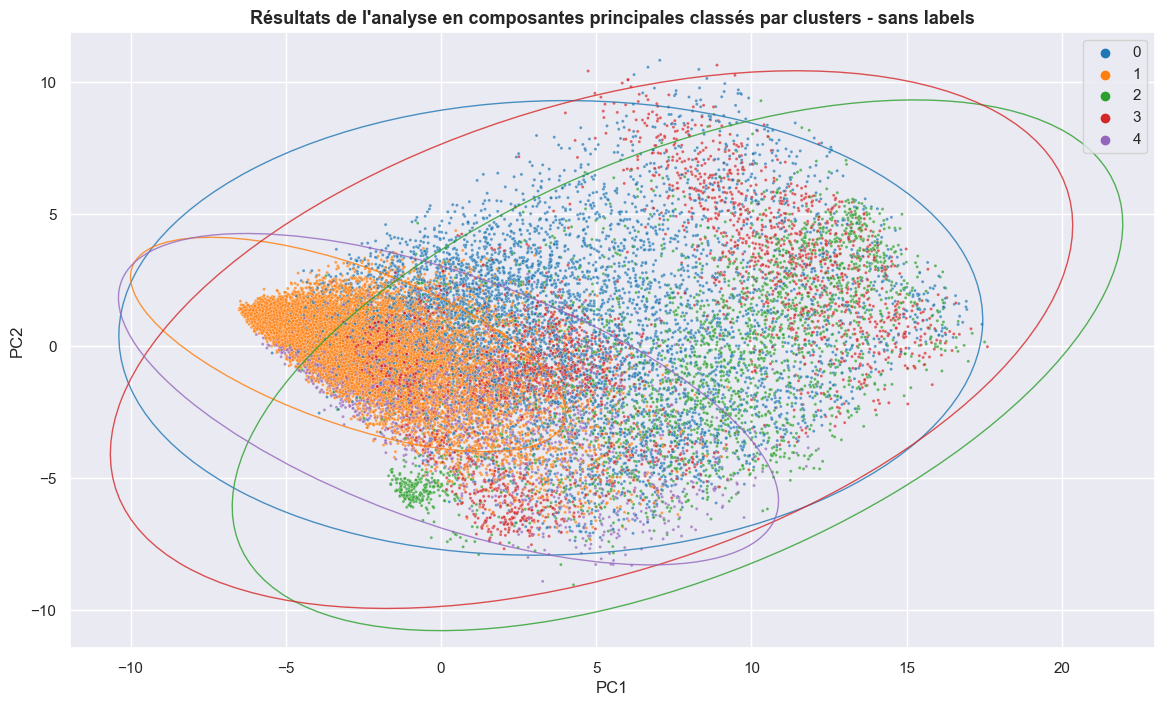

In [31]:
acp_df["Clusters"] = clusters

fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(8)
plt.title(f"Résultats de l'analyse en composantes principales classés par clusters - sans labels", fontsize = 13, fontweight = "bold")
sns.scatterplot(data=acp_df, x = "PC1", y = "PC2", hue = "Clusters", s = 5, alpha = 0.7, palette = "tab10")
              
for idx, cluster in enumerate(np.sort(acp_df["Clusters"].unique())):
    confidence_ellipse(x = acp_df[acp_df["Clusters"] == cluster]["PC1"].values,
                       y = acp_df[acp_df["Clusters"] == cluster]["PC2"].values,
                       ax = ax,
                       edgecolor = plt.cm.tab10.colors[idx],
                       #facecolor = plt.cm.tab10.colors[idx],
                       alpha = .8)         
plt.legend()
plt.show()

Au vu des résultats, peut être qu'un algorithme de clustering non linéaire serait pertinent, en effet nos données vivent peut être sur une variété, un "manifold". Il semble néanmoins difficile d'identifier une structure particulière avec un algorithme linéaire.

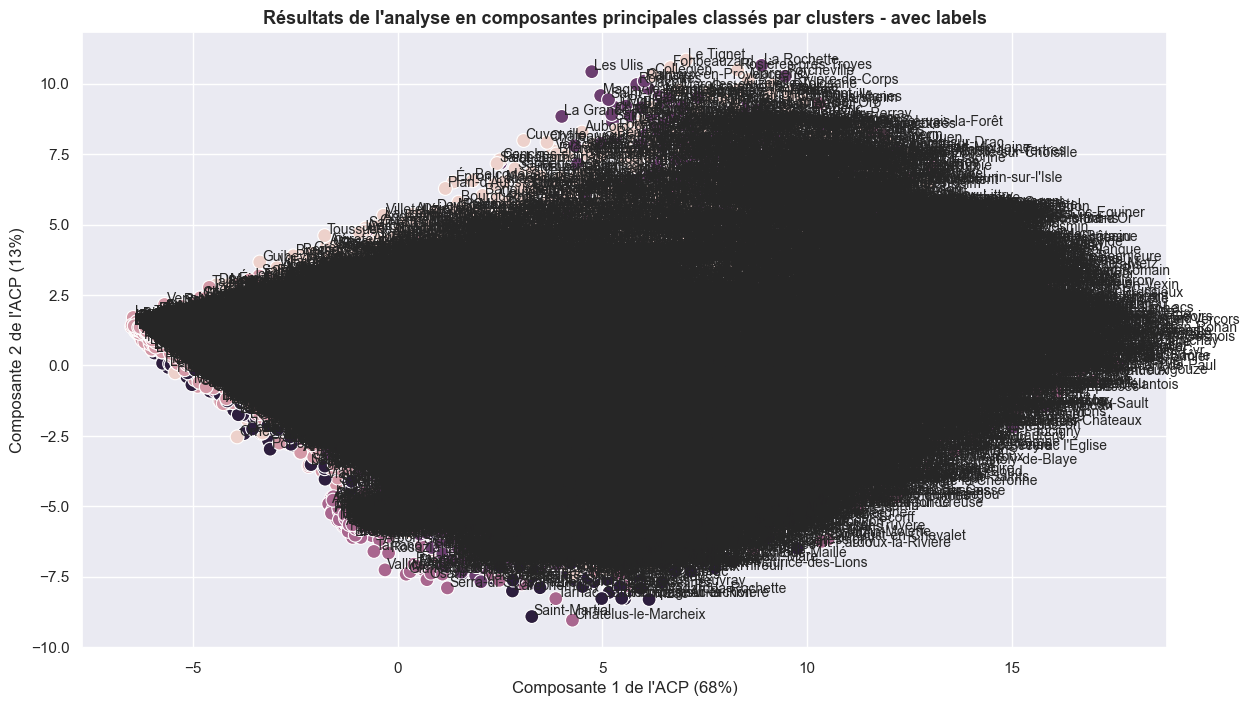

In [32]:
plt.figure(figsize = (14, 8))
sns.scatterplot(data = acp_df, x = "PC1", y = "PC2", s = 100, hue = "Clusters", marker = "o", alpha = 1, legend = None)
for i in acp_df.index:
    plt.text(acp_df["PC1"].iloc[i] + 0.05,
            acp_df["PC2"].iloc[i] + 0.05,
            acp_df["LIBGEO"].iloc[i],
            fontdict={"fontsize":10}) 
plt.xlabel(f"Composante 1 de l'ACP ({acp.explained_variance_ratio_[0] * 100:.0f}%)")
plt.ylabel(f"Composante 2 de l'ACP ({acp.explained_variance_ratio_[1] * 100:.0f}%)")
plt.title("Résultats de l'analyse en composantes principales classés par clusters - avec labels", fontsize = 13, fontweight = "bold")
plt.show()

## 2. Nous avons aussi essayé un Algorithme CAH
Le Clustering Aglomératif Hiérarchique (CAH) est une technique de clustering qui consiste à regrouper les éléments de données en utilisant une approche itérative de fusion de clusters.

In [33]:
# initialisation de la variable X
X = pd.DataFrame(merged_df.select_dtypes(include = np.number)).values

In [34]:
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
matrice_distance = linkage(X,metric='euclidean',method='ward')

In [38]:
#Graphique pour le dendogramme
#plt.figure(figsize=(10,30))
#plt.title("Distance entre departement (CAH)")
#dendrogram(matrice_distance,orientation="right",leaf_font_size=5,
#          color_threshold = 0.5e5,labels = merged_df.LIBGEO.str.strip().values
#          )
#plt.show()

Ici nous avons choissi un threshold (qui determine le seuil de decoupage des regroupements)est égale à 0.5e5. Ce seuil nous permet d'avoir un decoupage de 15 clusters.  On pouvait aller plus loin, mais en terme de representation d'endogramme reste toujours compliqué vu le grand nrb des communes dans le data set.

## Nous voulons également d'eclater le cluster en violet

In [39]:
# predictions pour chaque observation son cluster d'appartenance
seuil = 0.5e5
preds_clusters = fcluster(matrice_distance,t=seuil,criterion='distance') 

In [40]:
print(f"Nous obtenons {len(np.unique(preds_clusters))} clusters")

Nous obtenons 15 clusters


In [41]:
print(f"Notre jeu de données contient {X_scaled.shape[0]} observations")
print(f"Notre prediction contient {preds_clusters.shape[0]} observations")

Notre jeu de données contient 34957 observations
Notre prediction contient 34957 observations


In [42]:
for cluster in range(15):
    print(f"Le nombre d'observation du cluster {cluster+1} est : {sum(preds_clusters==cluster+1)}")

Le nombre d'observation du cluster 1 est : 6420
Le nombre d'observation du cluster 2 est : 5183
Le nombre d'observation du cluster 3 est : 6145
Le nombre d'observation du cluster 4 est : 1389
Le nombre d'observation du cluster 5 est : 3462
Le nombre d'observation du cluster 6 est : 1602
Le nombre d'observation du cluster 7 est : 1449
Le nombre d'observation du cluster 8 est : 790
Le nombre d'observation du cluster 9 est : 1663
Le nombre d'observation du cluster 10 est : 1065
Le nombre d'observation du cluster 11 est : 1499
Le nombre d'observation du cluster 12 est : 411
Le nombre d'observation du cluster 13 est : 1239
Le nombre d'observation du cluster 14 est : 1350
Le nombre d'observation du cluster 15 est : 1290


In [43]:
id_clusters = np.argsort(preds_clusters)
df_clusters = pd.DataFrame({"Communes":merged_df.LIBGEO.str.strip().values[id_clusters],
                            "cluster":preds_clusters[id_clusters]
                           })
df_clusters.head()

Communes  cluster
0         Sainte-Foy        1
1           Cadillon        1
2            Cabidos        1
3             Chalon        1
4  Bustince-Iriberry        1

## Interpretation des clusters en utilisant une ACP

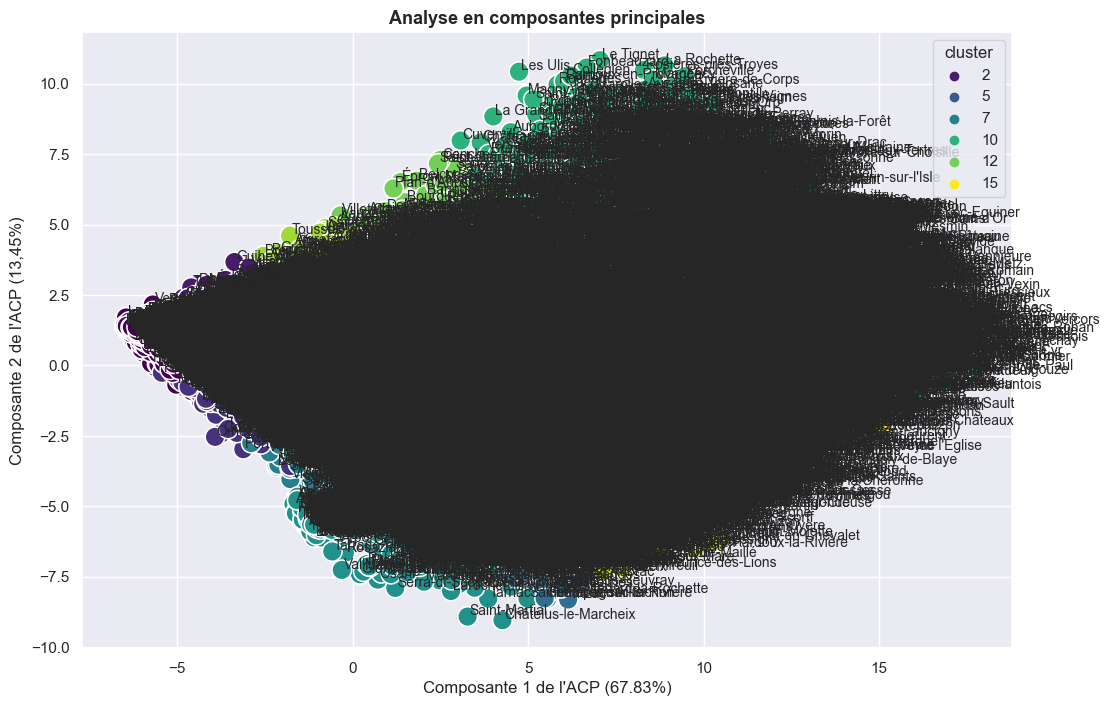

In [44]:
acp = PCA()
acp.fit(X_scaled)

## Stockage des nouvelles colonnes en dataframe
labels = list()
new_columns = acp.transform(X_scaled) # Calculer les nouvelles colonnes obtenues par l'acp

for i in range(1, new_columns.shape[1] + 1):
    labels.append(f"PCA_{i}")

df_new = pd.DataFrame(new_columns, columns = labels) # Stocker les nouvelles colonnes dans une dataframe pandas avec comme nom de colonnes [pca_1,pca_2,...] 
#df_new.head()

# Representer graphiquement les communes sur les deux premieres composante de l'acp
df_new["LIBGEO"] = merged_df["LIBGEO"]
df_new["cluster"] = preds_clusters

plt.figure(figsize = (12, 8))
sns.scatterplot(data = df_new, x = "PCA_1", y = "PCA_2", s = 200, palette= sns.color_palette("viridis", as_cmap = True), alpha = 1, hue = "cluster")

for i in range(merged_df.shape[0]):
    plt.text(df_new["PCA_1"].iloc[i] + 0.05,
            df_new["PCA_2"].iloc[i] + 0.05,
            df_new["LIBGEO"].iloc[i],
            fontdict={"fontsize":10})
    
plt.xlabel("Composante 1 de l'ACP (67.83%)")
plt.ylabel("Composante 2 de l'ACP (13,45%)")
plt.title("Analyse en composantes principales", fontsize = 13, fontweight = "bold")
plt.show()

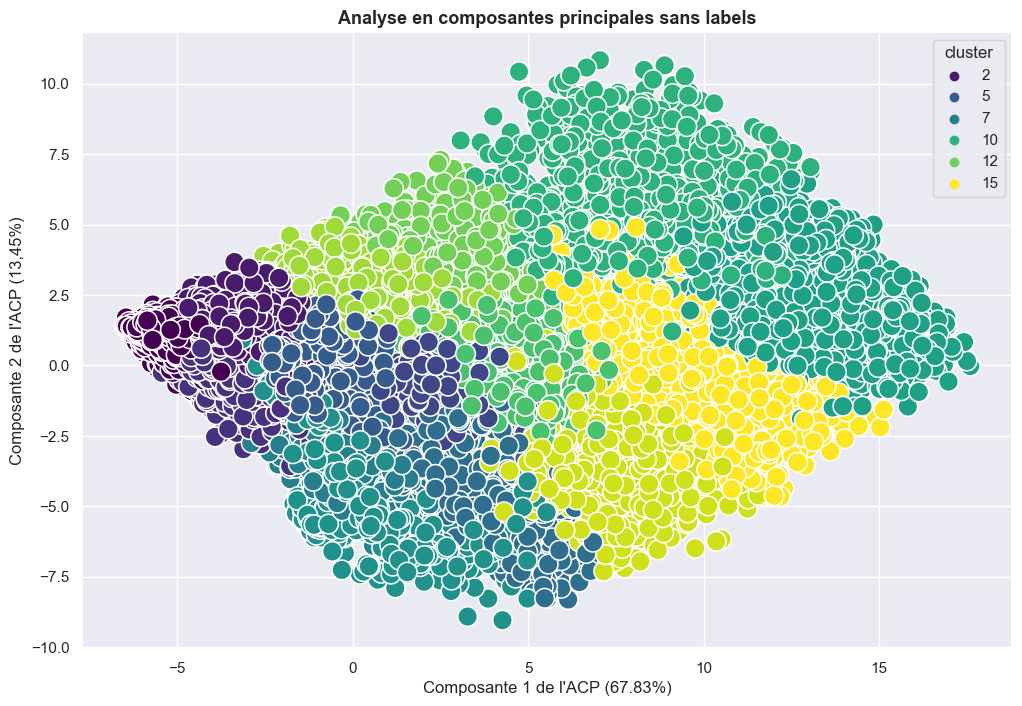

In [45]:
acp = PCA()
acp.fit(X_scaled)

## Stockage des nouvelles colonnes en dataframe
labels = list()
new_columns = acp.transform(X_scaled) # Calculer les nouvelles colonnes obtenues par l'acp

for i in range(1, new_columns.shape[1] + 1):
    labels.append(f"PCA_{i}")


df_new = pd.DataFrame(new_columns, columns = labels) # Stocker les nouvelles colonnes dans une dataframe pandas avec comme nom de colonnes [pca_1,pca_2,...] 
#df_new.head()

# Representer graphiquement les communes sur les deux premieres composante de l'acp
df_new["LIBGEO"] = merged_df["LIBGEO"]
df_new["cluster"] = preds_clusters

plt.figure(figsize = (12, 8))
sns.scatterplot(data = df_new, x = "PCA_1", y = "PCA_2", s = 200, palette= sns.color_palette("viridis", as_cmap = True), alpha = 1, hue = "cluster")

for i in range(merged_df.shape[0]):
    plt.text(df_new["PCA_1"].iloc[i] + 0.05,
            df_new["PCA_2"].iloc[i] + 0.05,
            _,
            fontdict={"fontsize":10})
    
plt.xlabel("Composante 1 de l'ACP (67.83%)")
plt.ylabel("Composante 2 de l'ACP (13,45%)")
plt.title("Analyse en composantes principales sans labels", fontsize = 13, fontweight = "bold")
plt.show()

En conclusion, les points semblent difficilement linéairement séparables, mais nous observons des clusters de points qui eux sont relativement bien définis par rapport à nos composantes principales. 

Donc, plus precisement, les 2 premieres composentes principales sont corrélées aux séries historiques de population (1876-2019) et l'axe 2 aux variables CODGEO.
Le graphique reste quand même difficile interpretable de maniere detaille, vu le grand nrb de communes qui sont quassiment imposible à lire sur le graphique labelisé (fait en premier).

## Machine Learning modèl:
### Entrainement d'un modèle de Neural Network

Shape : (46584, 36)
Nombre de NaN : 11
Shape après merge : (46573, 124)
Nombre de NaN après merge : 1741256
Shape : (46573, 124)


c:\Users\ababi\Desktop\Data_mining_Project_Mosef-main\Data_mining_Project_Mosef-main\src\tools.py:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(["Présent", "Manquant"], fontsize=12)


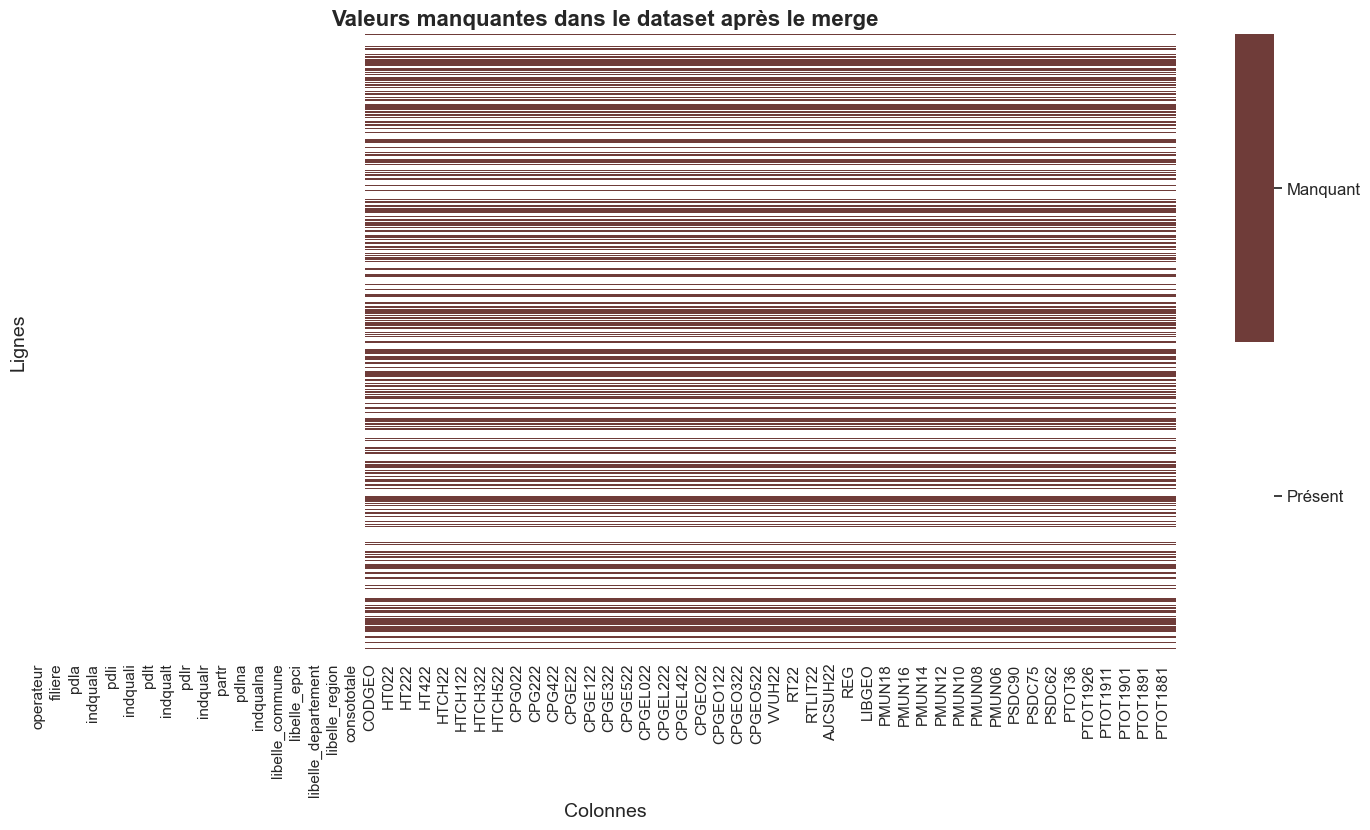

In [47]:
target_df = pd.read_csv("data/conso-elec-gaz-annuelle-par-secteur-dactivite-agregee-commune-france.csv", low_memory=False)
print("Shape :", target_df.shape)

#target_df.loc[target_df.filiere == "Electricité", :].reset_index(drop = True, inplace = True) # Nous ne sommes interessés que par la consommation
# electrique et non celle de gaz

print(f"Nombre de NaN : {target_df.isna().sum().sum()}")
target_df.dropna(axis = 0, inplace = True)

target_df = pd.merge(target_df, merged_df, how = "left", left_on = "code_postal", right_on = "CODGEO")
print(f"Shape après merge : {target_df.shape}")
print(f"Nombre de NaN après merge : {target_df.isna().sum().sum()}")

visualize_nan(target_df, "Valeurs manquantes dans le dataset après le merge")

On cherche à prédire 3 types de consommation : la consommation électrique relative à l'agriculture "consoa", celle relative à l'industrie "consoi", et celle relative au résidentiel "consor". Nous disposons égalements de deux autres types de consommations relatives au total : "consot" et "consototale".

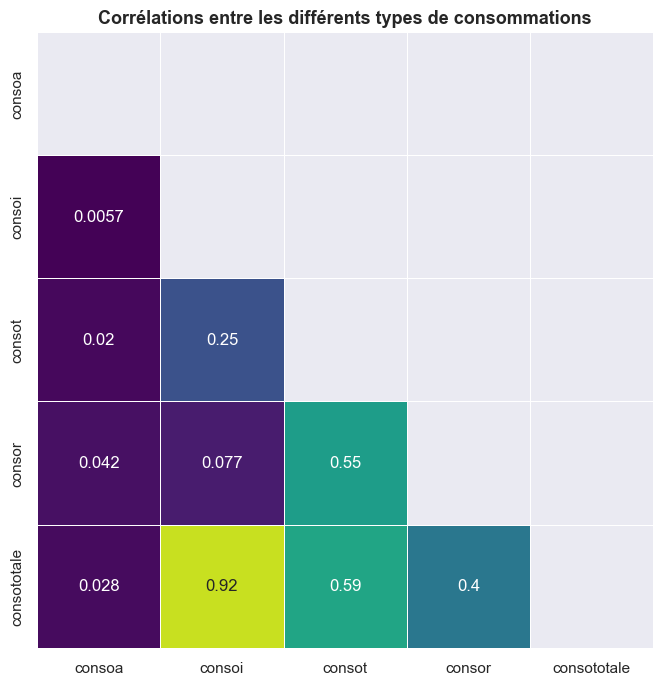

In [95]:
plt.figure(figsize = (14, 8))
plt.title(f"Corrélations entre les différents types de consommations", fontsize = 13, fontweight = "bold")
sns.heatmap(target_df.loc[:, ["consoa", "consoi", "consot", "consor", "consototale"]].corr(),
            mask = np.triu(target_df.loc[:, ["consoa", "consoi", "consot", "consor", "consototale"]].corr()),
            annot = True,
            square = True,
            linewidths=.5,
            vmin = 0,
            vmax = 1,
            cbar = False,
            cmap = "viridis")
plt.show()

Certaines corrélations sont fortement corrélées entre elles, notamment la consommation totale avec celle de l'industrie. Nous ferons ici le choix de tout garder; en effet, on peut vouloir prédire la consommation par secteur d'une ville a partir de sa consommation totale. Mais nous aurions aussi pu faire le choix d'enlever ces dernières en estimant qu'on ne dispose à priori d'aucune information vis à vis des consommations d'une commune.

In [96]:
target_df.loc[target_df.libelle_commune == "Narcy", [x for x in target_df.columns if "conso" in x or x == "filiere"]]

filiere  consoa     consoi      consot       consor  consona  \
230   Electricité     0.0   0.000000   76.034030   743.251637      0.0   
833   Electricité     0.0  64.182065  295.628456  1907.552245      0.0   
1846          Gaz     0.0   0.000000  133.777210   962.268060      0.0   

      consototale  
230    819.285667  
833   2267.362766  
1846  1096.045270

On remarque que certaines communes apparaissent plusieurs fois (ce n'est pas le cas de toutes). Affichons les corrélations des lignes sur 10 communes dupliquées (séléctionnées aléatoirement).

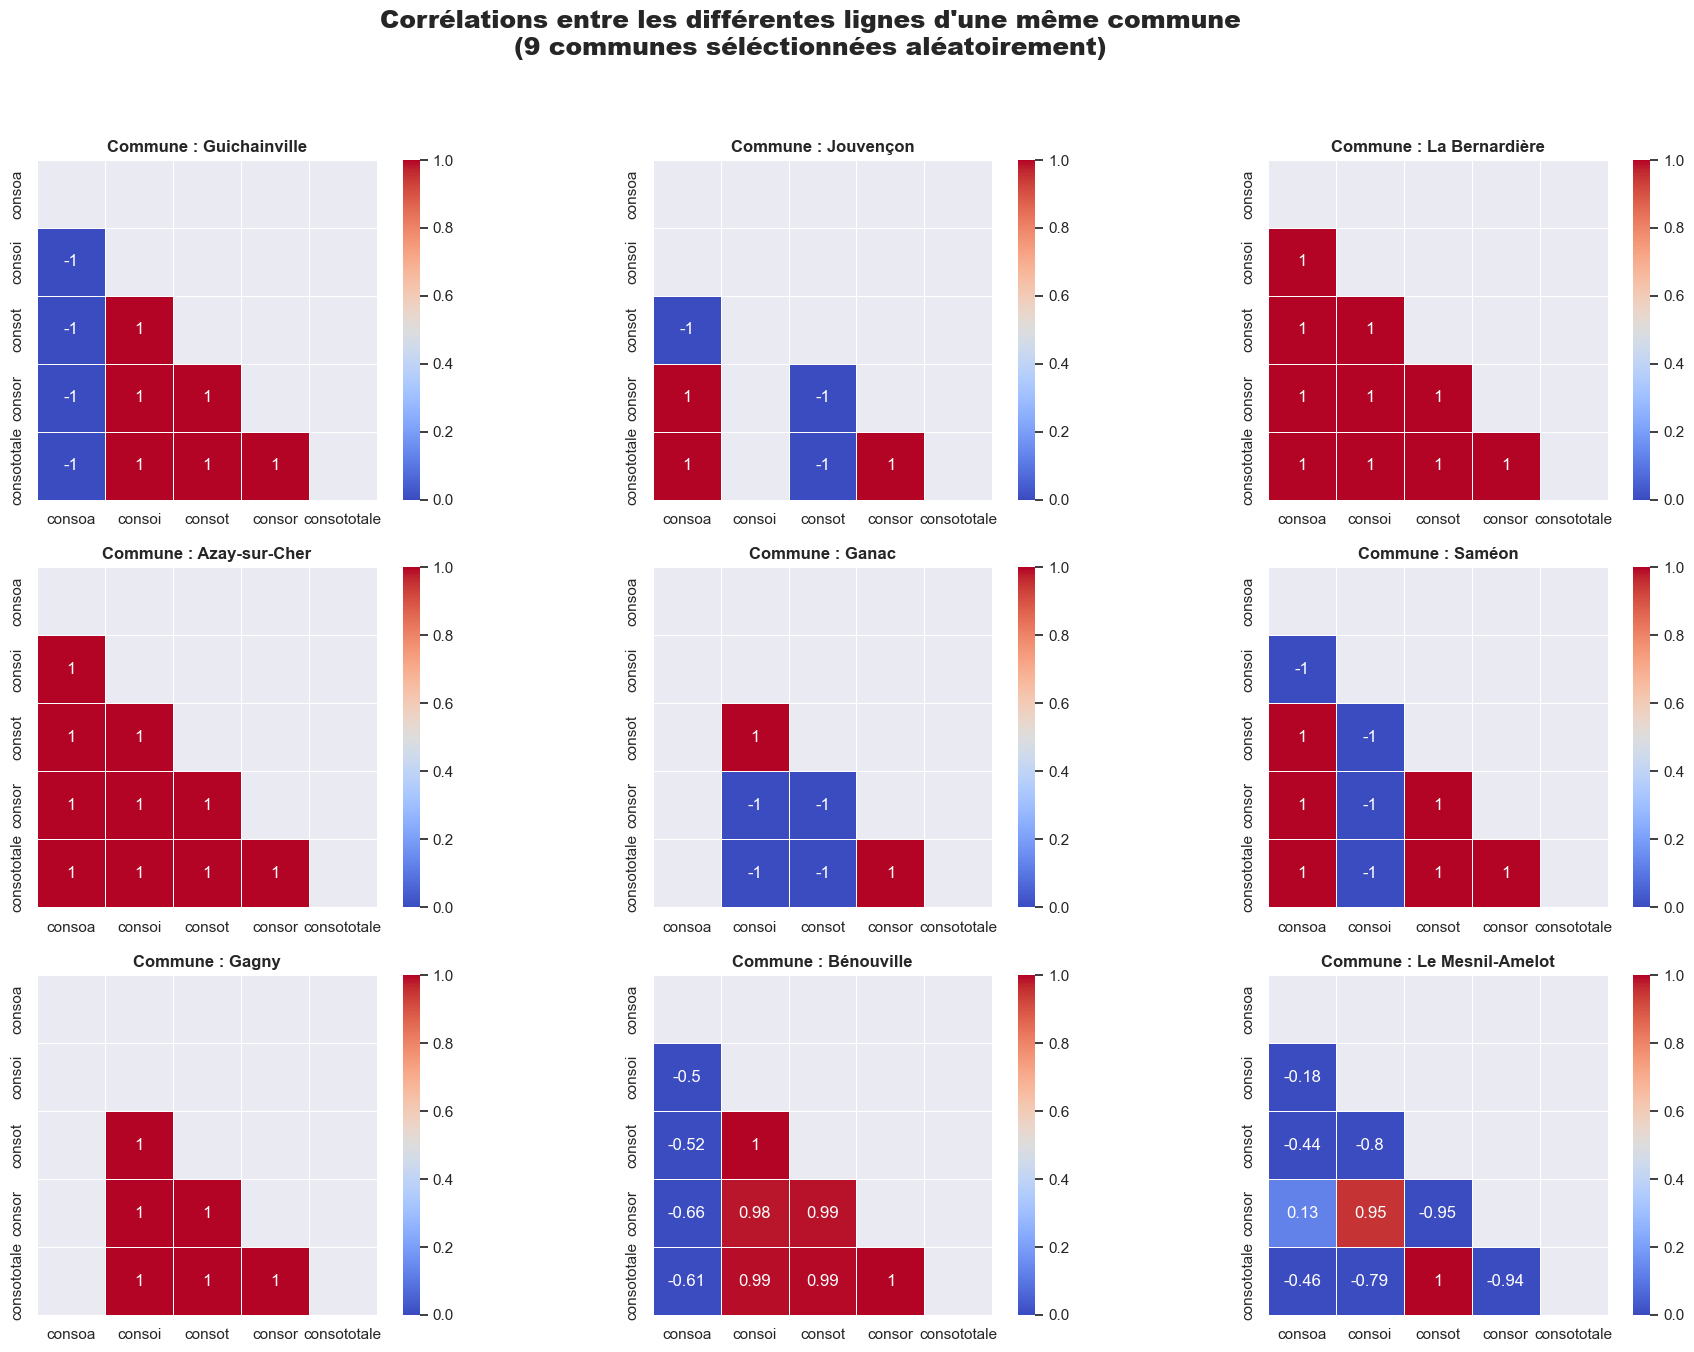

In [97]:
# Les consommations des différentes observations d'une même commune sont elles informatives ?
ncols = 3
sample_size = ncols * 3
nrows=(sample_size + ncols - 1) // ncols

fig, _ = plt.subplots(ncols=ncols, nrows=nrows, figsize=(7.5 * ncols, 5 * nrows), sharey=False)
fig.suptitle(f"Corrélations entre les différentes lignes d'une même commune\n({sample_size} communes séléctionnées aléatoirement)", 
             fontsize=18, 
             fontweight = "heavy")

for axe, commune in zip(fig.axes, target_df.loc[target_df.libelle_commune.duplicated(), "libelle_commune"].sample(sample_size)):
    axe.set_title(f"Commune : {commune}", fontweight = 'bold')
    sns.heatmap(target_df.loc[target_df.libelle_commune == commune, ["consoa", "consoi", "consot", "consor", "consototale"]].corr(),
                mask = np.triu(target_df.loc[target_df.libelle_commune == commune, ["consoa", "consoi", "consot", "consor", "consototale"]].corr()),
                annot = True,
                square = True,
                linewidths=.5,
                vmin = 0,
                vmax = 1,
                cmap = "coolwarm", 
                ax = axe)
plt.show()

On remarque que pour les observations revenants plusieurs fois, les différents types de corrélations sont très informatives les unes par rapport aux autres. Nous pourrions proposer un modèle en conséquence, scindant notre problème en 2 parties : une partie de modélisation relatives aux nouvelles villes et une partie relatives au ville déjà connues. Ici, nous nous cantonnerons à la prédiction d'un seul modèle pour l'ensemble par soucis de simplicité.

#### Split du dataset en train / test / validation

On dispose d'assez d'observation pour ne pas avoir recours à la cross-validation. Nous prenons donc un jeu de validation correspondant à 10% du train set (qui lui même représentais 2/3 des données).

A noter que l'on cherche à prédire les 3 types de consommations simultanément. La séparation du dataset se fait sans tenir compte des doublons. 

In [125]:
from sklearn.model_selection import train_test_split

y = np.array([target_df.consoi, target_df.consoa, target_df.consor]).T
X = target_df.drop(labels = ["consoi", "consoa", "consor"], axis = 1).select_dtypes(include = np.number) # On ne garde que les numériques

X.fillna(value = 0, inplace = True) # On remplace les NaN par des 0. De ce fait, les variables ou nous n'aurons pas d'informations vont être "éteintes"
# pendant l'entrainement du modèle. Nous nous permettons ce procédé de par la nature du modèle de réseau de neurones.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1)

## Ajustement du train set

In [99]:
import torch
import torch.nn as nn

Epoch 1: Train loss = 3068.8987 / Validation loss = 3486.4600
Epoch 2: Train loss = 1684.5192 / Validation loss = 2185.4358
Epoch 3: Train loss = 1093.8681 / Validation loss = 2156.5173
Epoch 4: Train loss = 1033.1826 / Validation loss = 1987.1084
Epoch 5: Train loss = 991.0478 / Validation loss = 1987.6266
Epoch 6: Train loss = 974.6848 / Validation loss = 2226.6599
Epoch 7: Train loss = 956.9656 / Validation loss = 1853.6587
Epoch 8: Train loss = 934.2337 / Validation loss = 1771.2123
Epoch 9: Train loss = 924.3829 / Validation loss = 1725.9663
Epoch 10: Train loss = 901.8994 / Validation loss = 1728.2374
Epoch 11: Train loss = 873.8991 / Validation loss = 1661.1166
Epoch 12: Train loss = 865.0273 / Validation loss = 1629.7216
Epoch 13: Train loss = 870.2053 / Validation loss = 1583.1567
Epoch 14: Train loss = 839.5122 / Validation loss = 1483.3275
Epoch 15: Train loss = 830.8446 / Validation loss = 1538.3572
Epoch 16: Train loss = 825.0034 / Validation loss = 1575.7439
Epoch 17: Tra

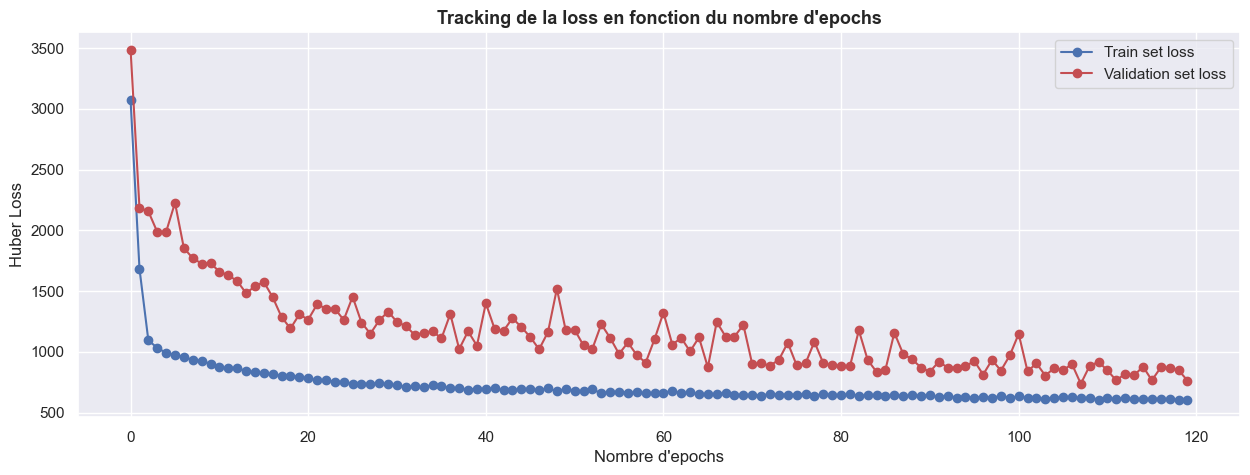

In [100]:
from src.model import NeuralNet

# On utilise un réseau dense, le code est disponible dans le script model.py
# Instanciation du modèle
input_size = X_train.shape[1]
hidden_size_1 = 2**6
hidden_size_2 = 2**4
# Le modèle est composé de 2 couches cachées (activation ReLU), une de 64 neurones et une de 16 neurones
num_outputs = y_train.shape[1]

model = NeuralNet(input_size, hidden_size_1, hidden_size_2, num_outputs)

# Define the loss function and optimizer
criterion = nn.HuberLoss(reduction="mean") # On utilise la Huber loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # On utilise Adam comme optimizer
nb_epochs = 120

fitted_model = model.fit(X_train.values, y_train, 
                                            X_val.values, y_val, 
                                            optimizer=optimizer, 
                                            loss_fn=criterion, 
                                            nb_epochs=nb_epochs)

_La fonction de coût de Huber est une fonction de coût utilisée en apprentissage automatique pour la régression. Elle combine les avantages de la fonction de coût quadratique et de la fonction de coût absolue. Elle est moins sensible aux valeurs aberrantes ("outliers") que la fonction de coût quadratique, mais est plus robuste que la fonction de coût absolue en raison de sa dérivée continue.
Sinon la Huber loss s'apparente a la MAE sauf aux alentours de 0 ou ça devient la MSE pour éviter les problèmes de dérivation._

La fonction de coût de Huber est définie comme suit:

$$f(y, ŷ) = {(y - ŷ)^2 / 2, si |y - ŷ| <= d; d(|y - ŷ| - d/2), sinon}$$

_où y est la valeur cible, ŷ est la prédiction du modèle, et d est un paramètre de seuil qui contrôle la transition entre la région quadratique et la région linéaire. Si la différence entre y et ŷ est inférieure ou égale à d, la fonction de coût est quadratique. Sinon, elle est linéaire.
Cette fonction est également utile lorsque la dérivée de la fonction de coût doit être continue, comme dans le cas de l'optimisation utilisant des algorithmes de descente de gradient._

Dans notre cas, la descente de gradient semble avoir quasiment convergée.

## Evaluation des résultats sur le test set

Pour évaluer le modèle, on calcule les mésures d'erreur classiques en régression (RMSE / MAE / R²). On ajoute à cela une mesure : la MAE/l'écart type des données, le tout en pourcentage. Cela pour mettre à l'échelle la MAE en la divisant par la mesure de dispersion de nos données.

In [101]:
from src.tools import compute_results
compute_results(y_test, fitted_model.predict(X_test.values)) # Les résultats du réseau de neurones sur le test set

Industrie  Agriculture    Résidence
RMSE          4914.136701  1592.679393  4538.385102
MAE            899.533258   152.332366   829.162661
MAE/std en %     0.713421     9.404883     3.339165
R²               0.666061     0.666061     0.666061

_Notre modèle semble bien performer sur l'industrie et les données résidencielles. En revanche, il semble un peu moins bien performer sur les données d'agriculture._

# ML modèle qui prédit la consommation électrique

In [48]:
variable_numerique = target_df.drop(labels = ["consoi", "consoa", "consor"], axis = 1).select_dtypes(include = np.number).columns
variable_categorielle = target_df.select_dtypes(exclude="number").columns
print(f"Variables numeriques = {len(variable_numerique)}; Variables categorielles = {len(variable_categorielle)}")

Variables numeriques = 108; Variables categorielles = 13


#### Avant de passer à l'étape de modélisation, nous avon décider de faire une imputation des NaN, par médiane pour les variables numeriques et par le mode pour les variables categorielles.

L'imputation par régression consiste à utiliser une régression pour prédire la valeur manquante d'une variable en utilisant les valeurs des autres variables (candidates). Pour utiliser l'imputation par régression, il faut d'abord entraîner un modèle de régression en utilisant les données que nous disposons. Ensuite, ce modèle est utilisé pour prédire les valeurs manquantes en utilisant les valeurs des autres variables comme entrées.
Aussi nous avons fais l'hypothese que l'imputation par chaînage de Markov peut être une approche efficace pour traiter les données manquantes dans notre cas. Mais le plus grand probleme dans ces deux cas est que nous ne disposons pas des features_candidates pertinantes pour faire une imputation par regression.

Donc, le plus simple et efficace moyenne de gerer les NaN  a été de recourir à une imputation classique par médianne.

In [50]:
from tqdm.auto import tqdm

In [51]:
# Pour les variables numeriques, nous avons recouru à une imputation par la médiane 
for c in variable_numerique:
    
    nb_val_mqte = target_df[c].isna().sum()
    if nb_val_mqte>0:
        var_moyenne = target_df[c].median()
        target_df[c] = target_df[c].fillna(var_moyenne)
        
# Pour les variables categorielles, nous avons recouru à une imputation par le mode 
for c in variable_categorielle:
    
    nb_val_mqte = target_df[c].isna().sum()
    if nb_val_mqte>0:
        var_mode_train = target_df[c].mode().values[0]
        target_df[c] = target_df[c].fillna(var_mode_train)

### Corrélation entre les variables 

In [52]:
binary_columns = target_df.columns[(target_df == 0).all() | (target_df == 1).all()]
non_binary_col =  target_df.columns[~((target_df == 0).any() | (target_df == 1).any())]
num = target_df[non_binary_col].select_dtypes(exclude = 'object').columns

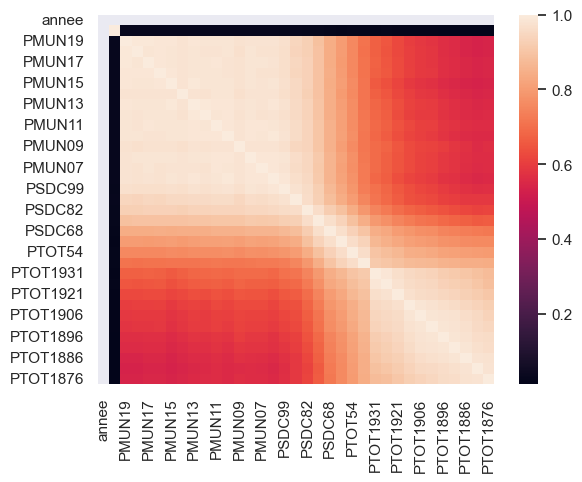

In [53]:
corr = target_df[num].corr()
sns.heatmap(corr)
plt.show()

Les variables semblent etre trés corrélées entre elles, donc nous avons choissi de faire un modèle de descente de gradient en ajoutant un L1 et L2 en amont, pour améliorer la performance de notre modèle, en penalisant le vecter de poids et en mettant les coefficients les plus corélés à 0.

In [56]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale

### # Prediction de la consommation électrique relative à l'industrie "consoi"

_Choix du modèle :_

Nous somme face à un probleme de regression (la variable cible qu'on cherche à prédire est quantitative). Plus précissement nous entrainons 3 modele de SGDRegressor en regularisant les hyperparametres à la main. Nous avons penser à fair un Grid searchCV, mais le temps de calcul pour un seul modèle dépassait 2h (très coutau en terme du temps), c'est la raison pour laquelle nous avons régler nous même les valeurs des hyperparamètres.
Nous avons opter pour un SGDRegressor car il est à la base un modèle de régression linéaire entraîné en utilisant la descente de gradient stochastique (SGD). Il prend en entrée plusieurs paramètres qui permettent de contrôler le comportement du modèle :

- _alpha_ : un terme de régularisation qui contrôle la complexité du modèle. Plus alpha est grand, plus le modèle sera simple et moins il y aura de risque de surapprentissage (overfitting). À l'inverse, plus alpha est petit, plus le modèle sera complexe et il y aura plus de risque de surapprentissage. Dans nos cas nous avons choisi alpha=0.01.

- _epsilon_ : utilisé pour définir la marge dans laquelle la prédiction du modèle peut être considérée comme précise.
Plus la valeur de epsilon est petite, plus le modèle sera exigeant en ce qui concerne la précision de ses prédictions et moins il y aura de risque de surapprentissage. À l'inverse, plus la valeur de epsilon est grande, plus le modèle sera tolérant en ce qui concerne la précision de ses prédictions et il y aura plus de risque de surapprentissage. Ici nous avons fixé une valeure de 0.1.

- _eta0_ : le taux d'apprentissage initial pour SGD.
Il détermine la vitesse à laquelle le modèle va se mettre à jour en fonction des nouvelles observations. Plus eta0 est grand, plus le modèle va rapidement s'adapter aux données et moins il y aura de risque de surapprentissage (overfitting). À l'inverse, plus eta0 est petit, plus le modèle va lentement s'adapter aux données et il y aura plus de risque de surapprentissage. Dans notre cas une valeure superieure de eta0=0.001 ne permetait pas au modele de converger.
 
- _penalty_ : spécifie le type de régularisation à utiliser dans le modèle. 
La régularisation est une technique utilisée pour empêcher le surapprentissage (overfitting) en ajoutant un terme de pénalité au coût de la fonction objectif du modèle. Nous avons choissi un elasticnet (une combinaison de L1 et L2). La régularisation L2 est ici utilisée dû fait queles variables sont corrélées et que l'on souhaite éviter que le modèle ne surapprenne. La régularisation L1 ici nous sert à sélectionner un sous-ensemble de features significatifs pour le modèle et éliminer les features non significatifs.

- En qualité des mesures de l'erreur d'un modèle de prédiction nous avons utilisé: R², MSE et RMSE.

R-squared: 0.9935800493064952
CV mean score:  0.9706130382502763
MSE:  0.006590536551113263
RMSE:  0.08118211965151725


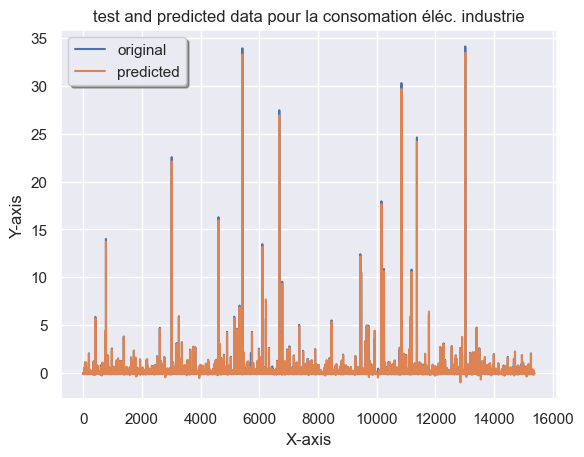

In [58]:
# Prediction de la consommation électrique relative à l'industrie "consoi"
y= target_df.consoi
X = target_df.drop(labels = ["consoi", "consoa", "consor"], axis = 1).select_dtypes(include = np.number) # On ne garde que les numériques
X = scale(X)
y = scale(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

#print(X_train.shape)
#print(y_train.shape)

sgdr = SGDRegressor(alpha=0.01, epsilon=0.1, eta0=0.001, penalty='elasticnet')
sgdr.fit(X_train, y_train)
score = sgdr.score(X_train, y_train)
print("R-squared:", score)

cv_score = cross_val_score(sgdr, X, y, cv=5)
print("CV mean score: ", cv_score.mean())  #afficher la performance de notre modèle à partir d'une cross validation

ypred = sgdr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("test and predicted data pour la consomation éléc. industrie")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

### # Prediction de la consommation électrique relative à l'agriculture "consoa"

R-squared: 0.06784145140474651
CV mean score:  0.19111547274351764
MSE:  0.5863652109120497
RMSE:  0.7657448732522143


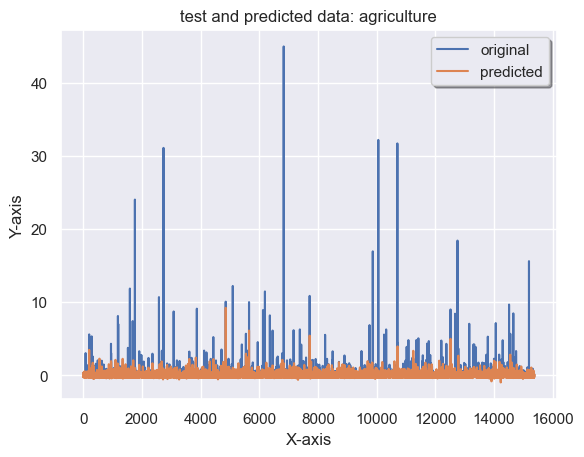

In [61]:
y= target_df.consoa
X = target_df.drop(labels = ["consoi", "consoa", "consor"], axis = 1).select_dtypes(include = np.number) 
X = scale(X)
y = scale(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

sgdr = SGDRegressor(alpha=0.01, epsilon=0.1, eta0=0.001, penalty='elasticnet')
sgdr.fit(X_train, y_train)

score = sgdr.score(X_train, y_train)
print("R-squared:", score)

cv_score = cross_val_score(sgdr, X, y, cv=5)
print("CV mean score: ", cv_score.mean()) 

ypred = sgdr.predict(X_test)

mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("test and predicted data: agriculture")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

### # Prediction de la consommation électrique relative au résidentiel "consor"

R-squared: 0.8596991076269025
CV mean score:  0.8017212511717939
MSE:  0.1040805249785394
RMSE:  0.3226151344536387


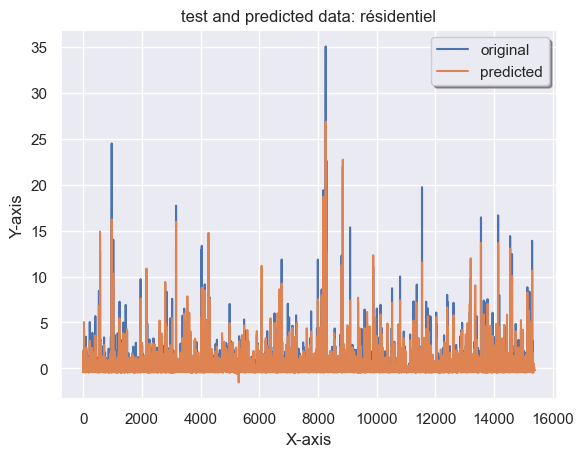

In [69]:
y= target_df.consor
X = target_df.drop(labels = ["consoi", "consoa", "consor"], axis = 1).select_dtypes(include = np.number) 
X = scale(X)
y = scale(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

sgdr = SGDRegressor(alpha=0.01, epsilon=0.1, eta0=0.001, penalty='elasticnet')
sgdr.fit(X_train, y_train)

score = sgdr.score(X_train, y_train)
print("R-squared:", score)

cv_score = cross_val_score(sgdr, X, y, cv=5)
print("CV mean score: ", cv_score.mean()) 

ypred = sgdr.predict(X_test)

mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("test and predicted data: résidentiel")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

### Conclusion !
* _Nous obtenons la même conclusion faite à partir du prémier modele de ML, c'est à dire qu'au final, les deux modèles (Neural network et SGDRegressor) semblent bien performer sur l'industrie et les données résidencielles. En revanche, ils semblent etre un peu moins performants sur les données d'agriculture._

## _Methode LIME (Local Interpretable Model-agnostic Explanations) pour l'interpretation des résultats de prédiction de consomation résidentielle (consor)_

Nous avons obté pour une explication à partir de modele LIME, car la sortie de LIME fournit un peu plus de détails que celle de SHAP car elle spécifie une plage de valeurs de caractéristiques qui font que cette caractéristique a son influence. 

In [87]:
import lime
import lime.lime_tabular  
features = target_df.drop(labels = ["consoi", "consoa", "consor"], axis = 1).select_dtypes(include = np.number).columns

training_data = target_df.drop(labels = ["consoi", "consoa", "consor"], axis = 1).select_dtypes(include = np.number)

explainer = lime.lime_tabular.LimeTabularExplainer(training_data=training_data.values, ## 2d array,
                    feature_names=features.values.tolist(), 
                    mode='regression',
                    verbose=1,
                    random_state= 1)

### _Interpretation d'une prediction_

In [96]:
j = 1 #observation 1'
exp_sgdr_consor = explainer.explain_instance(X_test[j], sgdr.predict, num_features=10)
exp_sgdr_consor.show_in_notebook(show_table=True)

Intercept 8433.844064925242
Prediction_local [-301.03608047]
Right: -0.4090537194157362


L'histogramme en baton nous monttre les poids de contribution de chaque variable pour la prediction de l'observation 1. A droite il est representé le tableau avec les valeurs actuelles des variables. 
Dans ce cas, le modèle d'approximation appris par LIME est un modèle de regression avec une intercept de 8433.84.

Par exemple, nous savons que PMUN12, PMUN19, PSDC99, sont des variables qui ont eu une influence positive sur la prédiction de la première observation; leurs valeurs étaient inférieure à 362, à 360 et réspectivement à 311. Les autres varibles ont une influence négative sur la prédiction. (SHAP ne fournit pas ces informations.).

Cependant, l'importance des fonctionnalités de LIME diffère de celle de SHAP. Étant donné que SHAP a une base théorique plus solide, la plupart des gens ont tendance à faire confiance à SHAP. Mais au final nous arrivons à faire presque les mêmes conceptions d'analyse.


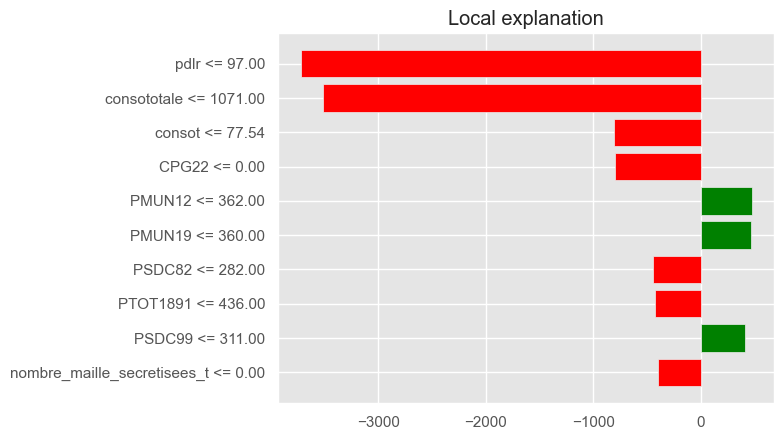

In [97]:
with plt.style.context("ggplot"):
    exp_sgdr_consor.as_pyplot_figure()

In [98]:
exp_sgdr_consor.as_list()

[('pdlr <= 97.00', -3721.3017012230957),
 ('consototale <= 1071.00', -3512.711603610496),
 ('consot <= 77.54', -809.3840102462932),
 ('CPG22 <= 0.00', -793.5777244058099),
 ('PMUN12 <= 362.00', 476.02239462004525),
 ('PMUN19 <= 360.00', 471.6416724028916),
 ('PSDC82 <= 282.00', -441.18985509354957),
 ('PTOT1891 <= 436.00', -428.05677357754325),
 ('PSDC99 <= 311.00', 416.60784473788937),
 ('nombre_maille_secretisees_t <= 0.00', -392.930389001053)]

Les variables qui sont corrélées positivement avec la target sont illustrées en vert et dans le cas de la prediction de la consomation éléctrique des résidentiels, on remarque plus des variables négativement corrélées avec la target (elles sont illustrées en rouge sur le graphique).